In [47]:
import matplotlib.pyplot as plt
import numpy as np
import wave
from random import sample
import pandas as pd
from scipy import fftpack
from scipy.signal import butter, filtfilt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go 

# Plotting

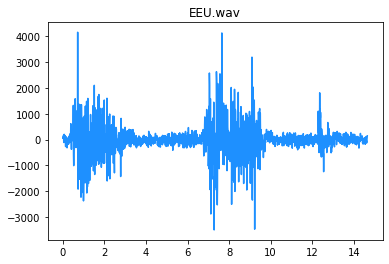

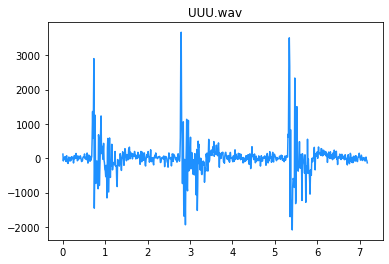

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


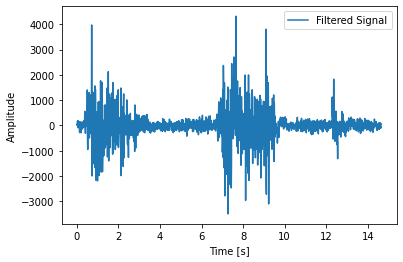

In [27]:
def plot_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    Time = np.linspace(0, len(signal) / fs, num=len(signal))

    plt.figure(1)
    title = str(path.split("arm_signal/")[-1])
    
    plt.title(title)
    plt.plot(Time[::100], signal[::100], color = 'dodgerblue')
    plt.show()

plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UUU.wav")




# Classifier

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


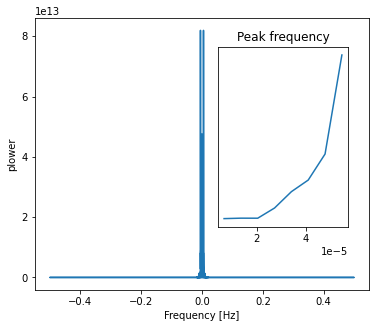

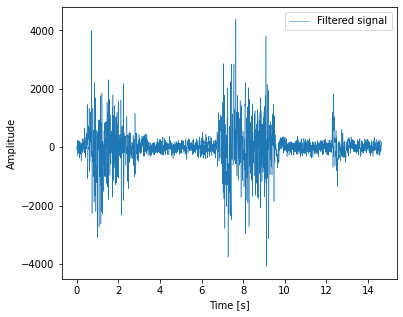

In [44]:
def filter_plot(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)**2
    period = 5

    # The corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size)

    # Plot the FFT power
    plt.figure(figsize=(6, 5))
    plt.plot(sample_freq, power)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('plower')

    # Find the peak frequency: we can focus on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]

    # Check that it does indeed correspond to the frequency that we generate
    # the signal with
    np.allclose(peak_freq, 1./period)

    # An inner plot to show the peak frequency
    axes = plt.axes([0.55, 0.3, 0.3, 0.5])
    plt.title('Peak frequency')
    plt.plot(freqs[:8], power[:8])
    plt.setp(axes, yticks=[])   

    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)

    plt.figure(figsize=(6, 5))
    plt.plot(Time, filtered_sig, linewidth=0.5, label='Filtered signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.legend(loc='best')
filter_plot("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")


In [55]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, fs, time 

signal,fs,time = prep_wave("arm_signal/EEU.wav")
nyq = 0.3*fs
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    
def fft(path):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = 2
    order = 2
    y = butter_lowpass_filter(signal, cutoff, fs, order)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                y = signal,
                line =  dict(shape =  'spline' ),
                name = 'signal with noise'
                ))
    fig.add_trace(go.Scatter(
                y = y,
                line =  dict(shape =  'spline' ),
                name = 'filtered signal'
                ))
    fig.show()
fft("arm_signal/EEU.wav")

    
    

In [4]:

def movement_classifier(data, time, down_sample_rate = 50, window_size = 0.3, threshold_events = 100):
    # able to modify these
    # window_size = 0.3 # could be 0.5, try all.
    # threshold_events = 50 # we can try 20
    # down_sample_rate = 50 # we can try 50 here aswell

    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)

    t_stat = [0]*len(ind)


    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)


    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] < threshold_events]

    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)

    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]

    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            intervals.append((int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000))
            cut_point = predicted_event[i+1]
    intervals.append((int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[-1]] + middle_time)/10000))

    return intervals

In [5]:

def movement_classifier_max(data, time, down_sample_rate = 50, window_size = 0.3, threshold_events = 1000):
    # able to modify these
    # window_size = 0.3 # could be 0.5, try all.
    # threshold_events = 50 # we can try 20
    # down_sample_rate = 50 # we can try 50 here aswell

    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)

    t_stat = [0]*len(ind)


    # 2. Calculating max
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.max(data_subset)


    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]

    # predictedEvent = [] 
    # for i in range(len(t_stat)-1):
    #     predictedEvent.append(np.where(t_stat[i] > threshold_events))


    # time vector for middle of each window 
    # time_middle = []
    # for i in predicted_event:
    #     time_middle.append(time[ind[i]] + window_size/2)

    # time_middle = []
    # for i in predictedEvent:
    #     time_middle.append(time[ind[i]] + window_size/2)


    # diff = np.diff(time_middle)
    # gaps = [] 

    # for i in range(len(gaps)):
    #     gaps.append(np.where(diff[i] > window_size))
    # # gaps = np.where(np.diff(time_middle) > window_size)

    # event_time_interval = [np.min(time_middle)]


    # for i in range(len(gaps)-1):
    #     event_time_interval.append((time_middle[gaps[i]],time_middle[gaps[i] + 1]))

    

    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]


    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            intervals.append((int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000))
            cut_point = predicted_event[i+1]
    intervals.append((int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[-1]] + middle_time)/10000))
    return intervals

# Preparing Wave File

In [6]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, fs, time 

SD [(0.002, 0.582), (0.622, 0.682), (0.742, 0.782), (0.822, 0.862), (0.922, 0.942), (0.982, 0.982), (1.022, 1.042), (1.102, 1.142), (1.182, 1.202), (1.262, 1.282), (1.322, 1.422), (1.502, 1.502), (1.542, 1.682), (1.742, 1.802), (1.842, 1.862), (1.902, 1.902), (1.942, 2.102), (2.142, 2.142), (2.182, 2.202), (2.282, 2.362), (2.402, 2.762), (2.802, 7.022), (7.122, 7.122), (7.202, 7.202), (7.242, 7.242), (7.342, 7.342), (7.422, 7.422), (7.482, 7.502), (7.542, 7.562), (7.602, 7.622), (7.662, 7.882), (7.922, 7.942), (7.982, 8.022), (8.062, 8.182), (8.242, 8.262), (8.302, 8.422), (8.482, 8.502), (8.542, 8.562), (8.602, 8.642), (8.682, 8.682), (8.742, 8.782), (8.862, 8.982), (9.022, 9.022), (9.062, 9.062), (9.102, 9.102), (9.142, 9.142), (9.182, 9.202), (9.242, 12.362), (12.422, 12.442), (12.482, 14.442)]


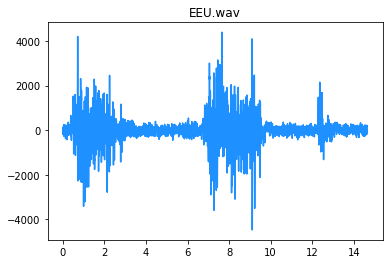

Max [(0.4952, 0.5002), (0.5852, 0.5902), (0.6402, 0.6402), (0.7052, 0.7152), (0.7602, 0.7752), (0.8502, 0.8602), (0.8852, 0.8952), (1.0302, 1.0302), (1.0802, 1.0802), (1.1352, 1.1402), (1.2002, 1.2102), (1.4502, 1.4552), (1.4902, 1.4902), (1.5102, 1.5152), (1.5402, 1.5402), (1.5702, 1.5752), (1.6002, 1.6002), (1.7002, 1.7002), (1.7302, 1.7352), (1.7602, 1.7602), (1.8152, 1.8202), (1.8402, 1.8402), (1.9302, 1.9302), (1.9602, 1.9602), (1.9852, 1.9902), (2.1152, 2.1202), (2.1652, 2.1652), (2.2452, 2.2452), (2.7952, 2.7952), (6.8252, 6.8252), (6.9202, 6.9202), (7.0202, 7.0252), (7.0502, 7.0602), (7.0952, 7.1002), (7.2602, 7.2652), (7.3902, 7.3902), (7.4002, 7.4002), (7.4502, 7.4552), (7.4752, 7.4802), (7.5002, 7.5002), (7.5452, 7.5652), (7.5852, 7.5852), (7.5952, 7.5952), (7.6402, 7.6552), (7.6752, 7.6752), (7.7202, 7.7402), (7.7802, 7.7802), (7.8552, 7.8602), (7.8852, 7.8902), (7.9152, 7.9202), (8.0852, 8.1102), (8.1752, 8.1752), (8.1952, 8.2002), (8.2552, 8.2702), (8.3002, 8.3102), (8.44

In [7]:
signal,fs,time = prep_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")
intervals = movement_classifier(signal, time = time, down_sample_rate = 200, window_size = 0.2, threshold_events = 225)
print("SD",intervals)


intervals_max = movement_classifier_max(signal, time = time, down_sample_rate = 50, window_size = 0.1, threshold_events = 1000)
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")
print("Max", intervals_max)

[(0.0005, 4.6905), (4.7005, 4.7055), (4.7155, 10.7055)]


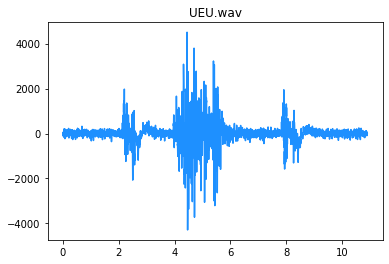

In [8]:
signal,fs,time = prep_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UEU.wav")
intervals = movement_classifier(signal, time = time, down_sample_rate = 50, window_size = 0.2, threshold_events = 250)
print(intervals)
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UEU.wav")

[(0.0005, 2.8405), (2.8505, 6.9805)]


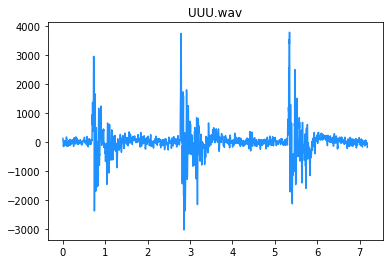

In [9]:
signal,fs,time = prep_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UUU.wav")
intervals = movement_classifier(signal, time = time, down_sample_rate = 50, window_size = 0.2, threshold_events = 250)
print(intervals)
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UUU.wav")